# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset
from countryguess.model import CustomEmbeddingModel, TripletModel
from countryguess.generate import TripletDataset, ValDataset
from countryguess.training import train, evaluate
from countryguess.plotting import plot_sample, plot_training_sample

## Plotting datasets

### Initialise datasets

In [10]:
shape=(160, 160)
train_data = TripletDataset(shape=shape, temp=0.9)
val_data = ValDataset(shape=shape, temp=0.9)
test_data = TestDataset(shape=shape)

INFO:countryguess.data:Loaded 70 samples from ./data/drawings/


### Plotting

#### Training data

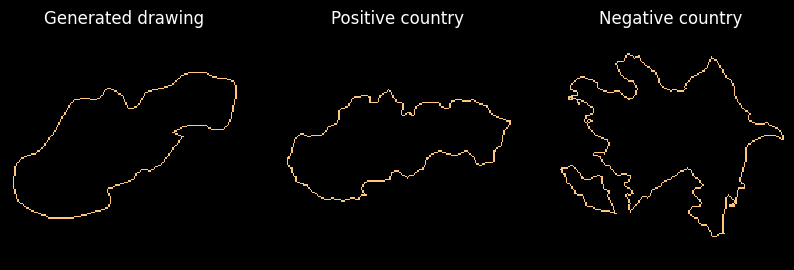

In [11]:
plot_training_sample(train_data)

#### Validation set

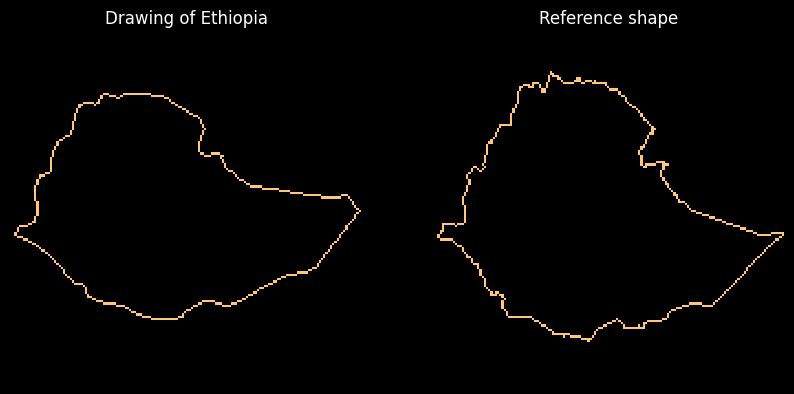

In [12]:
plot_sample(val_data)

#### Test set (user drawings)

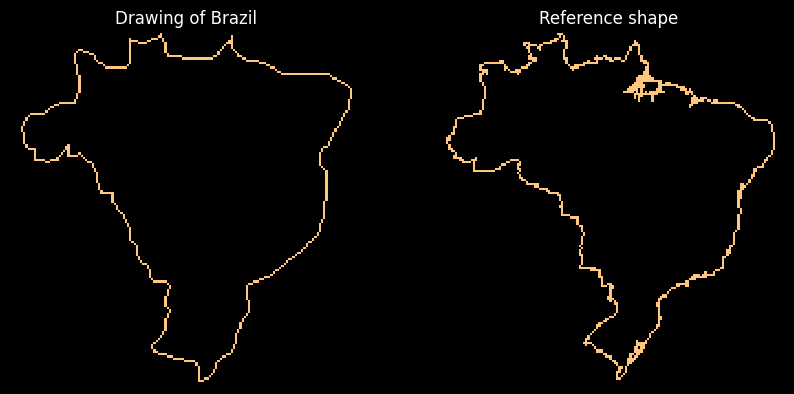

In [13]:
plot_sample(test_data)

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [ ]:
device = torch.device("mps")

In [ ]:
mlflow.set_experiment("local")

params = {
    "channels": 12, #4 * random.randint(2, 6),
    "nr_conv_blocks": 4, #random.randint(2, 5),
    "embedding_size": 768, #128 * random.randint(1, 8),
    "shape": 96, #32 * random.randint(1, 4),
    "learning_rate": random.uniform(0.006, 0.012),
    "margin": 0.8, #random.uniform(0.3, 1.2),
    "temperature": 0.6, #random.uniform(0.4, 1.1),
    "nr_epochs": 48, #random.randint(15, 75),
}

model = TripletModel(CustomEmbeddingModel(**params)).to(device)
params["embedding_model"] = model.embedding_model.__class__.__name__

optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"])
triplet_loss = nn.TripletMarginLoss(margin=params["margin"])

print("\n".join(f"{key}: {value}" for key, value in params.items()))

In [ ]:
# Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

# Initialise dataloaders
train_dl = DataLoader(train_data, batch_size=24, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=24, num_workers=2)

In [ ]:
with mlflow.start_run() as run:
    mlflow.log_params(params)

    # Start training
    for epoch in range(params["nr_epochs"]):
        loss = train(model, train_dl, triplet_loss, optimizer)
        mlflow.log_metric("loss", loss, epoch)
        print(
            "Epoch: {}/{}\t loss: {:.3f}".format(epoch + 1, params["nr_epochs"], loss)
        )

        if (epoch + 1) % 5 == 0:
            _, ranking = evaluate(model, val_dl, ref_data)

            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)

            print(
                "Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t".format(
                    epoch + 1,
                    params["nr_epochs"],
                    np.mean(ranking) + 1,
                    100 * np.mean(ranking < 10),
                    100 * np.mean(ranking < 1),
                )
            )

### Evaluate model

In [ ]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [ ]:
country_names, ranking = evaluate(model, test_dl, ref_data)

with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [ ]:
print("Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t"
      .format(np.mean(ranking) + 1, 100 * np.mean(ranking < 10), 100 * np.mean(ranking < 1)))

In [ ]:
# Sort the data based on ranking
sorted_data = sorted(zip(country_names, ranking), key=lambda x: x[1])
sorted_country_names, sorted_ranking = zip(*sorted_data)

# Plot the sorted horizontal bar chart
fig = plt.figure(figsize=(10, 12))  # Adjust figure size for vertical space
plt.barh(sorted_country_names, sorted_ranking, color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest rank at the top

# Add labels and title
plt.xlabel("Rank", fontsize=12)
plt.ylabel("Countries", fontsize=12)
plt.title("Countries Sorted by Rank", fontsize=14)
plt.xlim(0, 10)  # Ensure the x-axis matches the rank range
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines along the rank axis

# Show the improved plot
plt.tight_layout()
plt.show()

### Log model

In [ ]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

Make sure to set promote your desired model to the Model Registry using the MLFlow UI. The model with the champion alias will be used by the ML server.  You can set the name of the model within the docker-compose.yml file or by setting the environment variable MODEL_NAME if you run the app locally.

### Error Analysis
Let's look at the countries for which the model struggles. 

In [ ]:
print("Rank\tCountry")
for country, rank, in zip(country_names, ranking):
    if rank > 0:
        print(f"{int(rank+1)}\t{country}")